In [15]:
# using genetic algorithms to optimize simple machine learning models, such 
# as the random forest classifier, to implement brain tumor classification
# using tpot runs thru many models to find the best one
# The dataset used for this model is images of brain tumors available on Kaggle
# https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
# https://www.geeksforgeeks.org/random-forest-for-image-classification-using-opencv/

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from leap_ec import Individual, ops, util
from leap_ec.algorithm import generational_ea
from leap_ec.decoder import IdentityDecoder
from leap_ec.problem import ScalarProblem
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from toolz import pipe
from itertools import product
import seaborn as sns

In [17]:
# --- Genetic Algorithm Parameters ---
POP_SIZE = 50
GENERATIONS = 30
MUTATION_RATE = 0.5
CROSSOVER_RATE = 0.5
TOURNAMENT_SIZES = 5

# --- Hyperparameter search grid ---
n_estimators_options = list(range(50, 200, 1))
max_depth_options = list(range(1, 50, 1))  

In [18]:
# Load Dataset
def load_data(folder_path):
    X = []
    y = []
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                try:
                    img = Image.open(file_path).convert('L') 
                    img = img.resize((64, 64))  
                    img_array = np.array(img).flatten()
                    X.append(img_array)
                    y.append(class_name)
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
    return np.array(X), np.array(y)

X_train, y_train = load_data('brain_tumor_mri/Training')
X_test, y_test = load_data('brain_tumor_mri/Testing')

# Encode Labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [19]:
all_combinations = list(product(range(len(n_estimators_options)), range(len(max_depth_options))))

genome_counter = 0
def initialize_hyperparameters():
    global genome_counter
    if genome_counter >= len(all_combinations):
        genome_counter = 0  # or raise StopIteration if you're done
    i, j = all_combinations[genome_counter]
    genome_counter += 1
    return np.array([i, j])

def mutate_integer(population, search_space, p=0.1):
    for individual in population:
        for i, s in enumerate(search_space):
            if np.random.rand() < p:
                individual.genome[i] = np.random.randint(0, len(s))
        # decoded = [search_space[i][gene] for i, gene in enumerate(individual.genome)]
        yield individual

def uniform_crossover(population, p=0.5):
    offspring = []
    it = iter(population)
    for parent1 in it:
        try:
            parent2 = next(it)
        except StopIteration:
            offspring.append(parent1)
            break
        child1_genome = []
        child2_genome = []
        for gene1, gene2 in zip(parent1.genome, parent2.genome):
            if np.random.rand() < p:
                child1_genome.append(gene2)
                child2_genome.append(gene1)
            else:
                child1_genome.append(gene1)
                child2_genome.append(gene2)
        offspring.append(parent1.__class__(child1_genome))
        offspring.append(parent2.__class__(child2_genome))
    return offspring

In [20]:
fitness_cache = {}
clf = RandomForestClassifier(random_state=42)
class LeapGAProblem(ScalarProblem):
    def __init__(self):
        super().__init__(maximize=True)
        
    def evaluate(self, ind):
        global clf
        n_estimators = n_estimators_options[int(ind[0]) % len(n_estimators_options)]
        max_depth = max_depth_options[int(ind[1]) % len(max_depth_options)]

        key = (n_estimators, max_depth)

        if key in fitness_cache:
            print("Cache hit for key:", key)
            return fitness_cache[key]
        else:
            print("Cache miss for key:", key)

        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        clf.fit(X_train, y_train_encoded)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test_encoded, y_pred)
        fitness_cache[key] = accuracy
        return accuracy

In [21]:
parents = Individual.create_population(POP_SIZE,
                                       initialize=initialize_hyperparameters,
                                       decoder=IdentityDecoder(),
                                       problem=LeapGAProblem())

In [22]:
parents = Individual.evaluate_population(parents)

Cache miss for key: (50, 1)
Cache miss for key: (50, 2)
Cache miss for key: (50, 3)
Cache miss for key: (50, 4)
Cache miss for key: (50, 5)
Cache miss for key: (50, 6)
Cache miss for key: (50, 7)
Cache miss for key: (50, 8)
Cache miss for key: (50, 9)
Cache miss for key: (50, 10)
Cache miss for key: (50, 11)
Cache miss for key: (50, 12)
Cache miss for key: (50, 13)
Cache miss for key: (50, 14)
Cache miss for key: (50, 15)
Cache miss for key: (50, 16)
Cache miss for key: (50, 17)
Cache miss for key: (50, 18)
Cache miss for key: (50, 19)
Cache miss for key: (50, 20)
Cache miss for key: (50, 21)
Cache miss for key: (50, 22)
Cache miss for key: (50, 23)
Cache miss for key: (50, 24)
Cache miss for key: (50, 25)
Cache miss for key: (50, 26)
Cache miss for key: (50, 27)
Cache miss for key: (50, 28)
Cache miss for key: (50, 29)
Cache miss for key: (50, 30)
Cache miss for key: (50, 31)
Cache miss for key: (50, 32)
Cache miss for key: (50, 33)
Cache miss for key: (50, 34)
Cache miss for key: (50

In [23]:
generation_counter = util.inc_generation()
seen_combinations = set()
best_accuracies = []
avg_accuracies = []
log_rows = []

while generation_counter.generation() < GENERATIONS:
    print(f"Working on generation {generation_counter.generation() + 1}")
    offspring = pipe(parents,
                        ops.tournament_selection(k=TOURNAMENT_SIZES),
                        ops.clone,
                        lambda pop: mutate_integer(pop, search_space=[n_estimators_options, max_depth_options], p=MUTATION_RATE),
                        ops.UniformCrossover(p_xover=CROSSOVER_RATE),
                        ops.evaluate,
                        ops.pool(size=len(parents)),  # accumulate offspring
                    )  # increment to the next generation

    best = max(offspring, key=lambda ind: ind.fitness)

    avg_accuracy = np.mean([ind.fitness for ind in offspring])

    best_n_estimators = n_estimators_options[int(best.genome[0]) % len(n_estimators_options)]
    best_max_depth = max_depth_options[int(best.genome[1]) % len(max_depth_options)]

    all_n_estimators = [n_estimators_options[int(ind.genome[0]) % len(n_estimators_options)] for ind in offspring]
    all_max_depths = [max_depth_options[int(ind.genome[1]) % len(max_depth_options)] for ind in offspring]
    avg_n_estimators = np.mean(all_n_estimators)
    avg_max_depth = np.mean(all_max_depths)
    error = 1 - best.fitness
    avg_error = 1 - avg_accuracy

    for ind in offspring:
        n_estimators = n_estimators_options[int(ind.genome[0]) % len(n_estimators_options)]
        max_depth = max_depth_options[int(ind.genome[1]) % len(max_depth_options)]
        seen_combinations.add((n_estimators, max_depth))

    best_accuracies.append(best.fitness)
    avg_accuracies.append(avg_accuracy)

    log_rows.append([
        POP_SIZE,
        MUTATION_RATE,
        CROSSOVER_RATE,
        TOURNAMENT_SIZES,
        generation_counter.generation(),
        best.fitness,
        avg_accuracy,
        best_n_estimators,
        best_max_depth,
        avg_n_estimators,
        avg_max_depth,
        avg_error
    ])

    print(f"log row: {len(log_rows)}")

    parents = offspring
    generation_counter()



Working on generation 1
Cache hit for key: (50, 2)
Cache hit for key: (50, 24)
Cache miss for key: (51, 22)
Cache miss for key: (110, 45)
Cache miss for key: (122, 43)
Cache miss for key: (181, 2)
Cache hit for key: (50, 36)
Cache hit for key: (50, 34)
Cache hit for key: (50, 36)
Cache hit for key: (50, 40)
Cache hit for key: (50, 41)
Cache miss for key: (51, 6)
Cache miss for key: (56, 4)
Cache miss for key: (165, 21)
Cache hit for key: (50, 36)
Cache miss for key: (131, 43)
Cache hit for key: (50, 25)
Cache hit for key: (50, 47)
Cache hit for key: (50, 49)
Cache hit for key: (50, 43)
Cache hit for key: (50, 37)
Cache hit for key: (50, 16)
Cache hit for key: (50, 27)
Cache miss for key: (155, 36)
Cache miss for key: (63, 22)
Cache miss for key: (174, 3)
Cache hit for key: (50, 46)
Cache hit for key: (50, 16)
Cache miss for key: (143, 43)
Cache hit for key: (50, 47)
Cache hit for key: (50, 42)
Cache hit for key: (50, 43)
Cache hit for key: (50, 38)
Cache hit for key: (50, 1)
Cache hit 

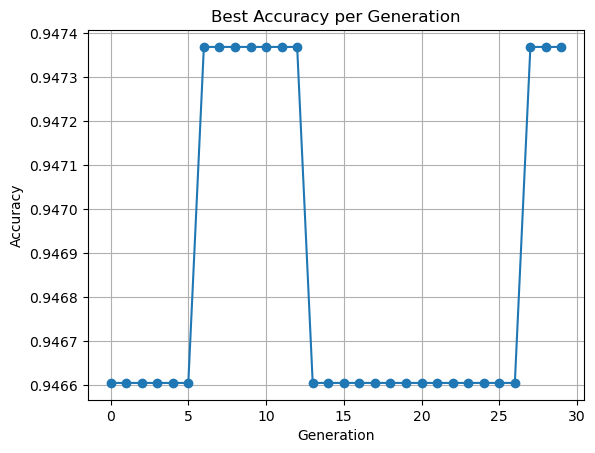

In [24]:
plt.plot(range(GENERATIONS), best_accuracies, marker='o')
plt.title('Best Accuracy per Generation')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

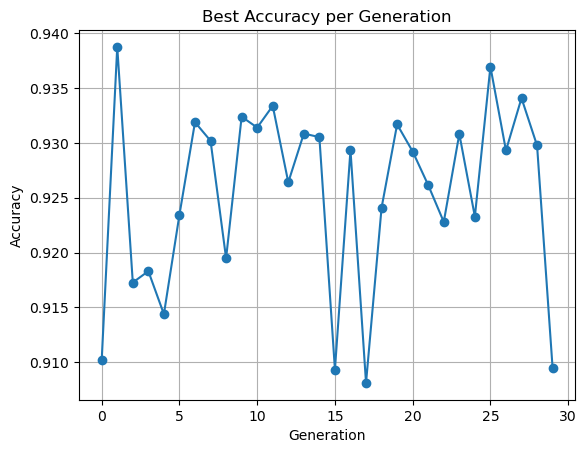

In [25]:
plt.plot(range(GENERATIONS), avg_accuracies, marker='o')
plt.title('Best Accuracy per Generation')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [26]:
with open("RF_LEAP_GA_50_cm_results.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Population", "Mutation_rate", "Crossover_rate", "tournament_size", "Generation", "Best_Accuracy", "Average_Accuracy", "Best_n_estimators", "Best_max_depth", "Avg_n_estimators", "Avg_max_depth", "Error_avg_accuracy"])
    writer.writerows(log_rows)

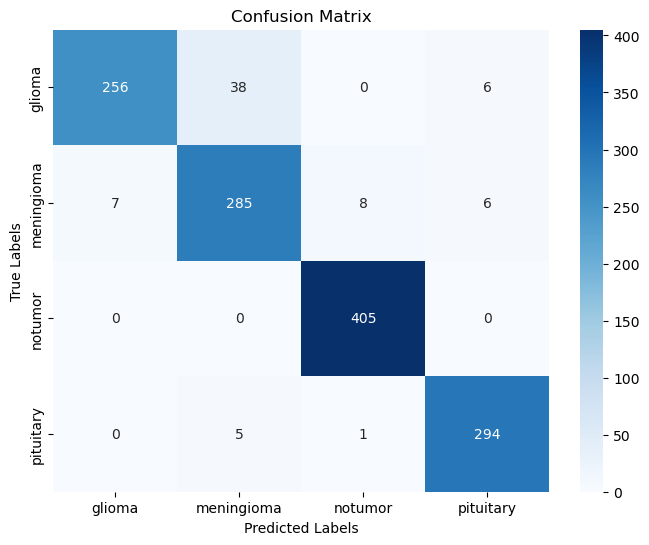

In [27]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
